Title: Base framework for estimation of Mutual Information using Neural Networks as applied to human images and gender labels.

Last Update: 08/15/2023

Developers: Rohan Soni, William (Bill) Wu, Homa Esfahanizadeh

Based on MINE Estimation repository by Homa Esfahanizadeh: https://github.com/hesfahanizadeh/MI_ESTIMATION_BASE

Also based on and inspired by the public repositories of the following papers:
- I. Belghazi, S. Rajeswar, A.  Baratin, R. D. Hjelm, and A. C. Courville, “MINE: mutual information neural estimation,” PMLR, 2018.
- K. Choi and S. Lee, “Regularized mutual information neural estimation,” Openreview, 2021.


In [13]:
# Install Necessary Packages
!pip install torch pytorch-lightning==1.9.4
!pip install torch

In [19]:
# Import Necessary Libraries
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from tqdm import tqdm #logs intermediate results

from torch.nn import functional as F

import math
import logging #logs intermediate results
logging.getLogger().setLevel(logging.ERROR)

#torch and torchvision import statements
#import torch
#import torchvision
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer, seed_everything
#import torch.nn as nn
#from pytorch_lightning.loggers import TensorBoardLogger
#from torch.utils.data import Dataset
#from torch.utils.data import DataLoader

#for different learning functions
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import os #for checking if directory exists and unzipping files
import matplotlib.pyplot as plt #for plotting MI estimations v. epoch

#mount Google drive for accessing zipped files, unzipping them, and storing final data/results
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
# Parameters and Constants
DATA_SAVE_PATH = "drive/MyDrive/Colab/Image Quality Results/data/"  # Location for saved classification datapoints
FIG_SAVE_PATH = "drive/MyDrive/Colab/Image Quality Results/figures/" # Location for saving graphical results
ZIPS_PATH = "drive/MyDrive/Colab/Zips/" #Location for storing zip files of all images (unzipping locally is faster)
ATTR_LOCATION = "drive/MyDrive/Colab/male_or_female.txt" #Location for all male/female labels

#comparing using drive to save data and local session to save data
#DATA_SAVE_PATH = ""
#Result: not much difference, so will continue to save and write data to GDrive directly

EPS = 1e-6 # Used in computing the gradient of loss when numerically estimating MI
MINE_EPOCHS = 2000 # Number of iterations for numerically estimating MI
MINE_BATCH_SIZE = 5000  # batch size for loading dataset into MINE
lr = 1e-4 # learning rate
avg_samples = 20 #last avg_samples samples will be averaged for calculation of MI

#image processing parameters
min_img_size = 5
max_img_size = 5
interval = 5

compression_rate = 50 #every compression_rate samples are averaged and plotted

In [22]:
#  Mutual Information Estimation Setup: Inspired by MINE and ReMINE papers

class T(nn.Module): # This is the function that its parameters are optimized to be used in estimation of MI
    def __init__(self, size1, size2):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(size1+size2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x1, x2):
        x1, x2 = x1.float().to(device), x2.float().to(device)
        x1 = x1.view(x1.size(0), -1).to(device)
        x2 = x2.view(x2.size(0), -1).to(device)
        cat = torch.cat((x1, x2), 1).to(device)
        return self.layers(cat).to(device)

class EMALoss(torch.autograd.Function): # exponential moving average.
    @staticmethod
    def forward(ctx, input, running_ema):
        ctx.save_for_backward(input, running_ema)
        input_log_sum_exp = input.exp().mean().log()
        return input_log_sum_exp

    @staticmethod
    def backward(ctx, grad_output): # Gradient
        input, running_mean = ctx.saved_tensors
        grad = grad_output * input.exp().detach() / \
            (running_mean + EPS) / input.shape[0]
        return grad, None

def ema_loss(x, running_mean, alpha):
    t_exp = torch.exp(torch.logsumexp(x, 0) - math.log(x.shape[0])).detach() # The second term is for going from sum to average
    if running_mean == 0:
        running_mean = t_exp
    else:
        running_mean = alpha * t_exp + (1.0 - alpha) * running_mean.item()
    t_log = EMALoss.apply(x, running_mean) # Forward

    return t_log, running_mean

class Mine(nn.Module):
    def __init__(self, stats_network, loss='mine', alpha=0.01, lam=0.1, C=0):
        super().__init__()
        self.running_mean = 0
        self.loss = loss
        self.alpha = alpha  # Used for ema during MINE iterations
        # Both lambda and C are a part of the regularization in ReMINE's objective
        self.lam = lam # Lambda
        self.C = C
        self.stats_network = stats_network # Function stat_net

    def forward(self, x, z, z_marg=None):
        if z_marg is None:
            z_marg = z[torch.randperm(x.shape[0])] # Permutation of z for marginal distribution

        stats_network_score = self.stats_network(x, z).mean() # The first terms in Remine Estimation
        t_marg = self.stats_network(x, z_marg)


        if self.loss in ['mine']:
            second_term, self.running_mean = ema_loss(
                t_marg, self.running_mean, self.alpha)
        elif self.loss in ['fdiv']:
            second_term = torch.exp(t_marg - 1).mean()
        elif self.loss in ['mine_biased']:
            second_term = torch.logsumexp(
                t_marg, 0) - math.log(t_marg.shape[0])

        # Introducing ReMINE regularization here
        return -stats_network_score + second_term + self.lam * (second_term - self.C) ** 2 # Minus sign is because of the minimization

class MutualInformationEstimator(pl.LightningModule):
    def __init__(self, loss='mine', **kwargs):
        super().__init__()
        self.energy_loss = kwargs.get('mine')
        self.file_name = kwargs.get('file_name') + ".txt"
        self.kwargs = kwargs
        self.gradient_batch_size = kwargs.get('gradient_batch_size', 1)
        self.train_loader = kwargs.get('train_loader')
        assert self.energy_loss is not None
        assert self.train_loader is not None
        print("energy loss: ", self.energy_loss)
        with open(DATA_SAVE_PATH + self.file_name, 'w') as f:
            pass # clear the file

    def forward(self, x, z):
        if self.on_gpu:
            x = x.to(device)
            z = z.to(device)

        return self.energy_loss(x, z)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.kwargs['lr'])

    def training_step(self, batch, batch_idx):
        x, z = batch
        if self.on_gpu:
            x = x.to(device)
            z = z.to(device)

        loss = self.energy_loss(x, z).to(device)
        mi = -loss
        tensorboard_logs = {'loss': loss, 'mi': mi}
        tqdm_dict = {'loss_tqdm': loss, 'mi': mi}
        self.last_mi = mi
        self.logger.experiment.add_scalar(
            f"MI Train",
            self.current_epoch,
            mi
        )
        self.logger.log_metrics(tensorboard_logs, self.current_epoch)

        if batch_idx % self.gradient_batch_size == 0:
            try:
              with open(DATA_SAVE_PATH + self.file_name, 'a') as f:
                  f.write(str(self.current_epoch)+'\t'+str(mi.tolist())+'\n')
            except FileNotFoundError:
              i = 0
              while not os.isdir(DATA_SAVE_PATH + self.file_name):
                print("File not found error randomly popped up.")
                i += 1
                if i > 50:
                  break
              with open(DATA_SAVE_PATH + self.file_name, 'a') as f:
                  f.write(str(self.current_epoch)+'\t'+str(mi.tolist())+'\n')
        return {
            **tensorboard_logs, 'log': tensorboard_logs, 'progress_bar': tqdm_dict
        }
    def test_step(self, batch, batch_idx):
        x, z = batch
        loss = self.energy_loss(x, z).to(device)

        return {
            'test_loss': loss, 'test_mi': -loss
        }

    def optimizer_step(self, epoch: int, batch_idx: int, optimizer, optimizer_idx: int = 0, optimizer_closure = None, on_tpu: bool = False, using_native_amp: bool = False, using_lbfgs: bool = False):
        if batch_idx % self.gradient_batch_size == 0:
            optimizer.step(closure=optimizer_closure)
        else:
            # REFACTOR: Aassumes optimizer closure always non-null
            optimizer_closure()

    def optimizer_zero_grad(self, epoch: int, batch_idx: int, optimizer, optimizer_idx: int):
        if batch_idx % self.gradient_batch_size == 0:
            optimizer.zero_grad()

    def train_dataloader(self):
        assert self.train_loader is not None
        return self.train_loader

#kept between new and original (will have to convert to Synthetic dataset after creating tensor and ndarray)
class SyntheticDataset(Dataset):
    def __init__(self, data1, data2):
        self.data1 = data1
        self.data2 = data2

    def __getitem__(self, index):
        x = self.data1[index]
        z = self.data2[index]
        return x, z

    def __len__(self):
        return len(self.data1)


#my own class created for converting images and labels to tensors and np arrays, respectively
def image_database(num_images, image_size, gray_or_color, randomness):
  convert_tensor = transforms.ToTensor()

  #convert male or female text file to array
  y_train = []
  labels_file = open(ATTR_LOCATION).readlines()
  for i in range(num_images):
    y_train.append(float(labels_file[i][0])) #grabs only the 0 or 1 as a float
  y_train = np.array(y_train) #creates ndarray from the list of male/female values
  #y_train = torch.FloatTensor(y_train) #NOT USEFUL (wrong type) creates a tensor out of that list

  X_train = []
  for i in range(1, num_images+1):

    #create 6-character number name
    new_filename = str(i)
    for j in range(6 - len(new_filename)):
      new_filename = "0" + new_filename

    img_folder = f"60ksamples_size{image_size[0]}x{image_size[1]}"

    #img = Image.open(f"drive/MyDrive/Colab/Batches/{img_folder}/" + str(new_filename) + f"_processed_size{image_size[0]}x{image_size[1]}.jpg")
    img = Image.open(f"{img_folder}/{str(new_filename)}_processed_size{image_size[0]}x{image_size[1]}.jpg")
    img_tensor = convert_tensor(img) #has a size equal to the total number of pixels
    X_train.append(img_tensor)
    if i % 2000 == 0:
      print(f"Finished {i}th image tensor.")

  X_train = torch.stack([i for i in X_train]) #concatenate list of image tensors to a single tensor
  X_train = X_train.reshape(-1, image_size[0]*image_size[1]).float()
  print(type(X_train), X_train.size, type(y_train), y_train.size)
  synthetic = SyntheticDataset(X_train, y_train)
  return [synthetic, X_train, y_train]

NameError: ignored

Doing image size 5x5 now.



INFO:lightning_fabric.utilities.seed:Global seed set to 1


cuda:0
Finished 2000th image tensor.
Finished 4000th image tensor.
Finished 6000th image tensor.
Finished 8000th image tensor.
Finished 10000th image tensor.
Finished 12000th image tensor.
Finished 14000th image tensor.
Finished 16000th image tensor.
Finished 18000th image tensor.
Finished 20000th image tensor.
Finished 22000th image tensor.
Finished 24000th image tensor.
Finished 26000th image tensor.
Finished 28000th image tensor.
Finished 30000th image tensor.
Finished 32000th image tensor.
Finished 34000th image tensor.
Finished 36000th image tensor.
Finished 38000th image tensor.
Finished 40000th image tensor.
Finished 42000th image tensor.
Finished 44000th image tensor.
Finished 46000th image tensor.
Finished 48000th image tensor.
Finished 50000th image tensor.
Finished 52000th image tensor.
Finished 54000th image tensor.
Finished 56000th image tensor.
Finished 58000th image tensor.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory lightning_logs/CelebA MI Estimations Size 5x5 utility BS=5000/I(X;L(X)), BS: 5000/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type | Params
-------------------------------------
0 | energy_loss | Mine | 12.9 K
-------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0

Finished 60000th image tensor.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x78d1a6f53510> <class 'numpy.ndarray'> 60000
energy loss:  Mine(
  (stats_network): T(
    (layers): Sequential(
      (0): Linear(in_features=26, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:362: LightningDeprecationWarning: The NVIDIA/apex AMP implementation has been deprecated upstream. Consequently, its integration inside PyTorch Lightning has been deprecated in v1.9.0 and will be removed in v2.0.0. The `MutualInformationEstimator.optimizer_step()` hook is overridden, including the `using_native_amp` argument. Removing this argument will avoid this message, you can expect it to return True.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2000` reached.


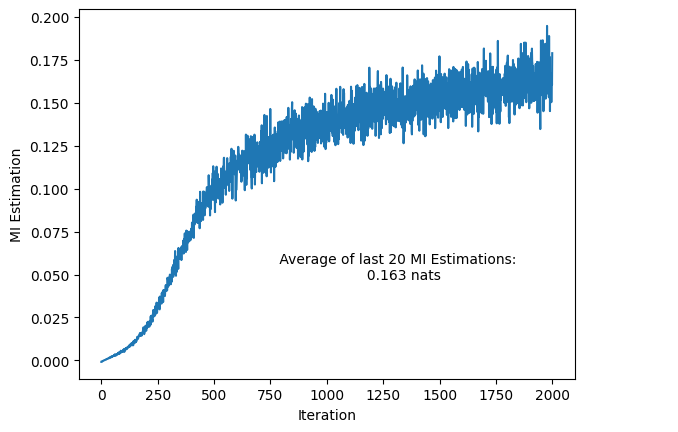

Doing image size 10x10 now.



INFO:lightning_fabric.utilities.seed:Global seed set to 1


cuda:0
Finished 2000th image tensor.
Finished 4000th image tensor.
Finished 6000th image tensor.
Finished 8000th image tensor.
Finished 10000th image tensor.
Finished 12000th image tensor.
Finished 14000th image tensor.
Finished 16000th image tensor.
Finished 18000th image tensor.
Finished 20000th image tensor.
Finished 22000th image tensor.
Finished 24000th image tensor.
Finished 26000th image tensor.
Finished 28000th image tensor.
Finished 30000th image tensor.
Finished 32000th image tensor.
Finished 34000th image tensor.
Finished 36000th image tensor.
Finished 38000th image tensor.
Finished 40000th image tensor.
Finished 42000th image tensor.
Finished 44000th image tensor.
Finished 46000th image tensor.
Finished 48000th image tensor.
Finished 50000th image tensor.
Finished 52000th image tensor.
Finished 54000th image tensor.
Finished 56000th image tensor.
Finished 58000th image tensor.
Finished 60000th image tensor.
<class 'torch.Tensor'> <built-in method size of Tensor object at 0x

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type | Params
-------------------------------------
0 | energy_loss | Mine | 20.4 K
-------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K    Total params
0.082     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Exception ignored in: <function _xla_gc_callback at 0x78d20ac98940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


ValueError: ignored

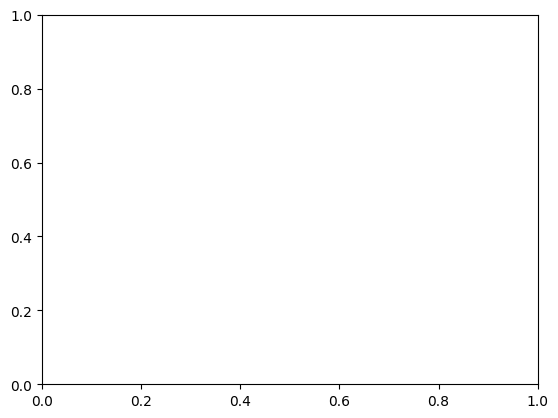

In [ ]:
#import statements for being able to run this cell alone
import os
import torch
import torchvision
from torchvision import transforms
import numpy as np
from PIL import Image

MI_averages = []
MI_estimation_curves = []
#perform MI estimation and generate MI estimation curve for every image size
for curr_img_size in range(min_img_size, max_img_size+interval, interval):
  print(f"Doing image size {curr_img_size}x{curr_img_size} now.\n")
  #run the rest of the program

  #unzip corresponding image file
  os.system(f"unzip {ZIPS_PATH}60ksamples_size{curr_img_size}x{curr_img_size}")

  # Set Computing Device
  device = 'cuda:0' if torch.cuda.is_available() else 'cpu'   #cuda:0 or cuda:1 for our 2-GPU testbed
  num_gpus = 1 if device=='cuda:0' else 0
  print(device)

  # Set Random Seed
  seed = 1
  seed_everything(seed, workers=True)
  # Torch RNG
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  # Numpy RNG
  np.random.seed(seed)

  img_size = (curr_img_size, curr_img_size) #pixel size of images in dataset

  #my code to convert all the images into tensors and the list of F/M labels to an ndarray (numpy)
  og_train_dataset, X_train, y_train = image_database(60000, img_size, "gray", False)

  N_FEATURES = X_train.shape[1] # Number of features per sample (total number of pixels)
  GRADIENT_BATCH_SIZE =  X_train.shape[0]/MINE_BATCH_SIZE  # How many gradients get accumulated before update (zero_grad)

  # Calculate H(L(X))=I(X,L(X))

  EXPERIMENT = f"CelebA MI Estimations Size {curr_img_size}x{curr_img_size}"
  train_loader_HLx = DataLoader(og_train_dataset, batch_size=MINE_BATCH_SIZE, shuffle=True)

  t = T(N_FEATURES,1).to(device)
  mi_estimator = Mine(t, loss='mine').to(device)
  func_str = f"I(X;L(X))"

  kwargs = {
      'mine': mi_estimator,
      'lr': lr,
      'batch_size': MINE_BATCH_SIZE,
      'alpha': 0.1,
      'func': func_str,
      'train_loader': train_loader_HLx,
      # Determines how many minibatches (MINE iters) of gradients get accumulated before optimizer step gets applied
      # Meant to stabilize the MINE curve for better encoder training performance
      'gradient_batch_size': GRADIENT_BATCH_SIZE,
      'file_name': f'Raw_MI_{img_size[0]}x{img_size[1]}'
  }

  logger = TensorBoardLogger(
      "lightning_logs",
      name=f"{EXPERIMENT} utility BS={MINE_BATCH_SIZE}",
      version=f"{func_str}, BS: {MINE_BATCH_SIZE}"
  )

  model = MutualInformationEstimator(loss='mine', **kwargs).to(device)

  trainer = Trainer(max_epochs=MINE_EPOCHS, logger=logger, accelerator="gpu")
  trainer.fit(model)

  # Printing MI Estimations
  itr_vec = range(MINE_EPOCHS)

  MI_epoch_est = []

  for line in open(DATA_SAVE_PATH+f'Raw_MI_{img_size[0]}x{img_size[1]}.txt', "r"):
      itr, est = line.split()
      MI_epoch_est.append(float(est))

  MI_estimation_curves.append(MI_epoch_est)

  #append MI_averages with average MI from this image size
  avg_MI = sum(MI_epoch_est[len(MI_epoch_est)-avg_samples:])/avg_samples #calculate average MI from last avg_samples samples
  MI_averages.append(avg_MI)

  plt.figure()
  plt.title(f"MI for {curr_img_size}x{curr_img_size} Pixels")
  plt.plot(itr_vec, MI_epoch_est)
  plt.ylabel('MI Estimation', fontname="Times New Roman")
  plt.xlabel('Iteration', fontname="Times New Roman" )

  #print average of last 20 estimations
  pad = 100
  xoff, yoff = -850, -0.05 #change for positioning average label differently
  plt.text(max(itr_vec)/2 + xoff, max(MI_epoch_est)/2 + yoff, f"Average of last 20 MI Estimations:".center(pad) + "\n" + f"{round(avg_MI, 3)} nats".center(pad+15), fontname="Times New Roman")

  plt.savefig(FIG_SAVE_PATH+f'MI_curve_size{img_size[0]}x{img_size[1]}.png')
  plt.show()

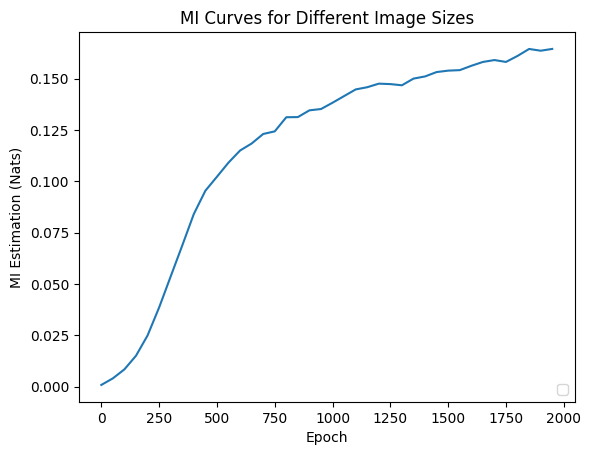

In [23]:
#take average of every n samples of a dataset to make it smoother (less noise)
def compress_raw_list(og_raw_list, n):
    float_list = []
    for j in og_raw_list:
        float_list.append(float(j))

    sublists = []
    for i in range(0, len(og_raw_list), n):
        curr_list = float_list[i:i+n] #only the next n values
        sublists.append(curr_list) #curr_list is temporary
    return [sum(i)/len(i) for i in sublists] #average all the sublists

#plot all MI estimation curves for all image sizes vs. epoch

#generate range of image sizes
legend = [f"Size {k}x{k}" for k in range(min_img_size, max_img_size+interval, interval)]

#compress all MI estimation curves
compressed_MI_curves = []
MI_epoch_est =[]

for i in range(min_img_size, max_img_size+interval, interval):
  for line in open(DATA_SAVE_PATH+f'Raw_MI_{i}x{i}.txt', "r"):
      itr, est = line.split()
      MI_epoch_est.append(float(est))
  compressed_MI_curves.append(compress_raw_list(MI_epoch_est, compression_rate))

#plot all curves
plt.figure()
plt.title("MI Curves for Different Image Sizes")
plt.ylabel("MI Estimation (Nats)")
plt.xlabel("Epoch")
for i in compressed_MI_curves:
  epoch_range = [compression_rate*j for j in range(len(i))]
  plt.plot(epoch_range, i)

plt.legend(loc="lower right")

plt.savefig(FIG_SAVE_PATH + "Img_Size_MI_Curves.png")
plt.show()

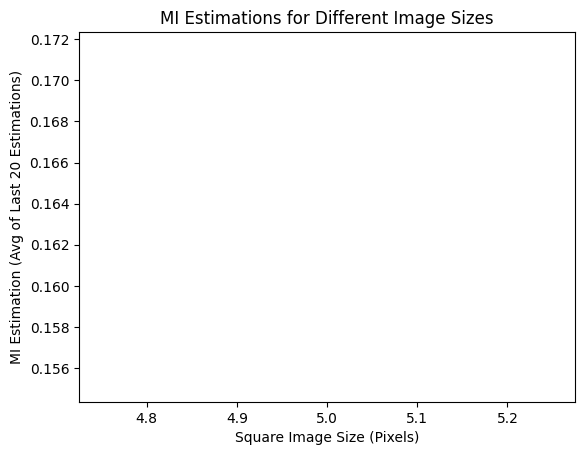

In [29]:
MI_averages = []
est = []
itr = []
for i in range(min_img_size, max_img_size+interval, interval):
  for line in open(DATA_SAVE_PATH+f'Raw_MI_{i}x{i}.txt', "r"):
      est.append(float(line.split()[1]))
  MI_averages.append(sum(est[-avg_samples:]) / avg_samples)
  compressed_MI_curves.append(compress_raw_list(MI_epoch_est, compression_rate))

#generate range of image sizes
img_sizes = [i for i in range(min_img_size, max_img_size+interval, interval)]

#plot MI estimation averages vs. image size in pixels
plt.figure()
plt.title("MI Estimations for Different Image Sizes")
plt.plot(img_sizes, MI_averages)
plt.ylabel(f"MI Estimation (Avg of Last {avg_samples} Estimations)")
plt.xlabel("Square Image Size (Pixels)")
plt.savefig(FIG_SAVE_PATH + "MI_vs_Compression.png")
plt.show()

In [ ]:
#disconnect runtime after finished with estimations
from google.colab import runtime
runtime.unassign()